In [1]:
import numpy
import pandas

import json

In [2]:
with open("helpers/config.json", "r") as fid:
    cfg = json.load(fid)

cfg

{'connectome': {'loading': {'conntility': '/scratch/datasets/microns_reimann/microns_mm3_connectome.h5',
   'args': ['condensed']},
  'subnetwork': {'base_volume': [],
   'simplices': [{'column': 'cell_type',
     'function': 'isin',
     'args': [['23P', '4P', '6CT', '5P_IT', '5P_PT', '5P_NP', '6IT']]},
    {'column': 'x_nm', 'function': 'gt', 'args': [700000]},
    {'column': 'x_nm', 'function': 'lt', 'args': [1200000]},
    {'column': 'z_nm', 'function': 'gt', 'args': [700000]},
    {'column': 'z_nm', 'function': 'lt', 'args': [1000000]}],
   'neurons': {'name': 'Inhibitory',
    'filters': [{'column': 'cell_type',
      'function': 'isin',
      'args': [['BC', 'MC', 'NGC']]}]}}},
 'analysis': {'simplex_dimension': 6,
  'use_weight': 0,
  'min_degrees': {'In': 200, 'Out': 200},
  'normalize_mat': 0,
  'clustering': {'use': 'source',
   'cluster_param': 2.2,
   'merge_smaller_than': 0.05,
   'normalize_cluster_paths': 'target',
   'normalize_cluster_disyn': 'target',
   'cutoff': {'

In [3]:
from helpers import network

M = network.load_network(cfg["connectome"]["loading"])
Msmpl = network.filter_network(M, cfg["connectome"]["subnetwork"]["simplices"])
name_nrn = cfg["connectome"]["subnetwork"]["neurons"]["name"]
Mnrn = network.filter_network(M, cfg["connectome"]["subnetwork"]["neurons"]["filters"])

In [4]:
#### RANDOMIZATION. OPTIONAL
from helpers.randomization import create_dd_control_networks

if "randomization" in cfg["connectome"].keys():
    cols_coords = cfg["connectome"]["randomization"]["cols_coords"]
    model_name = cfg["connectome"]["randomization"]["model_name"] # Currently not used!
    Msmpl, Mnrn = create_dd_control_networks(M, Msmpl, Mnrn, cols_coords, model_name, cfg)

In [5]:
from helpers import analysis

dimensions = [cfg["analysis"]["simplex_dimension"]]
#dimensions = [3, 4]

simplices, df_gids, df_idxs, ugids = analysis.get_simplex_dataframes(Msmpl, dimensions)
ugid = ugids[0]
df_gid = df_gids[0]
df_idx = df_idxs[0]
tgt_dim = dimensions[0]

 2023-11-10 17:39:10,037: COMPUTE list of simplices by dimension
100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.63it/s]


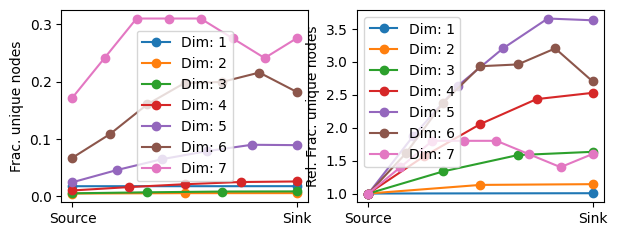

In [6]:
from helpers import plotting, analysis

fig = plotting.plot_simplex_divergences(analysis.get_divergences(simplices))

In [7]:
m_nrn_smpl, m_smpl_nrn = analysis.exc_inh_sparce_matrices(M, ugid, Mnrn.gids)
s_n_paths, n_s_paths = analysis.get_simplex_neuron_path_df(m_nrn_smpl, m_smpl_nrn, df_idx, name_nrn)

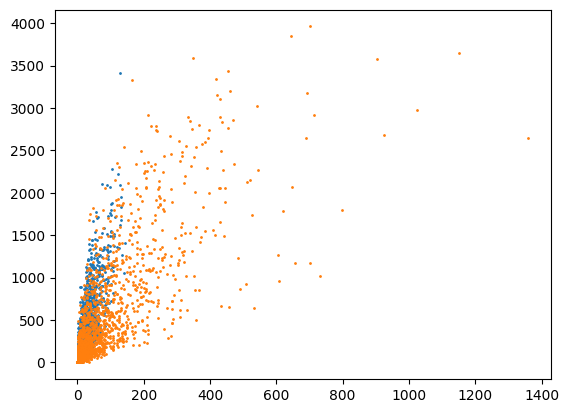

In [8]:
from matplotlib import pyplot as plt

nrn_degrees = analysis.simplex_specific_inout_degrees(s_n_paths, n_s_paths, name_nrn)

classic_indeg = numpy.array(m_smpl_nrn.sum(axis=0)).flatten()
classic_outdeg = numpy.array(m_nrn_smpl.sum(axis=1)).flatten()

plt.plot(classic_indeg, nrn_degrees["In"].reindex(range(len(classic_indeg))), '.', ms=2)
plt.plot(classic_outdeg, nrn_degrees["Out"].reindex(range(len(classic_indeg))), '.', ms=2)

[[1.         0.73563109]
 [0.73563109 1.        ]]


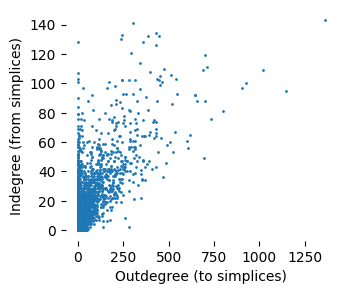

In [9]:
fig = plotting.plot_inout_degrees(m_nrn_smpl, m_smpl_nrn)

Text(0.5, 1.0, 'Inhibitory -> Simplex')

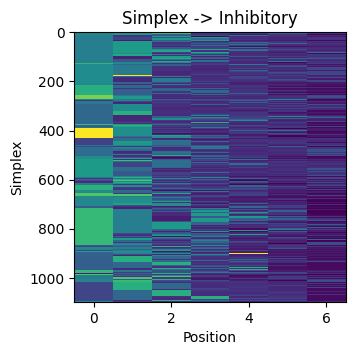

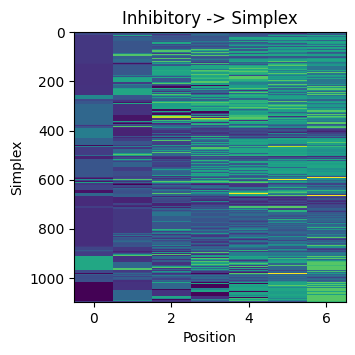

In [10]:
fig1 = plotting.plot_position_degrees(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_degrees(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

Text(0.5, 1.0, 'Inhibitory -> Simplex')

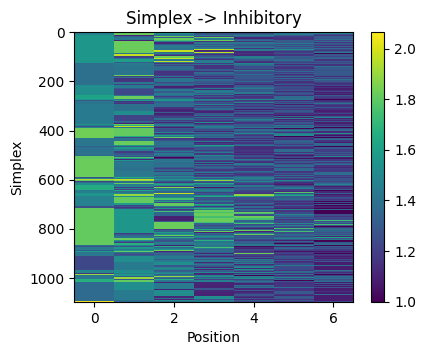

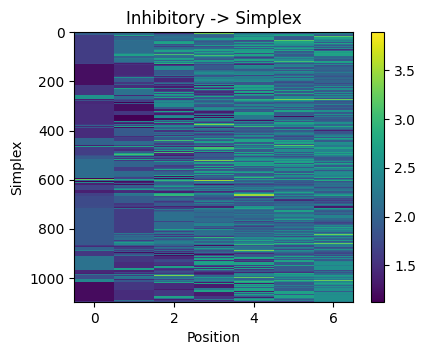

In [11]:
fig1 = plotting.plot_position_mean(s_n_paths)
ax = plt.gcf().gca()
ax.set_title("Simplex -> {0}".format(name_nrn))

fig2 = plotting.plot_position_mean(n_s_paths)
ax = plt.gcf().gca()
ax.set_title("{0} -> Simplex".format(name_nrn))

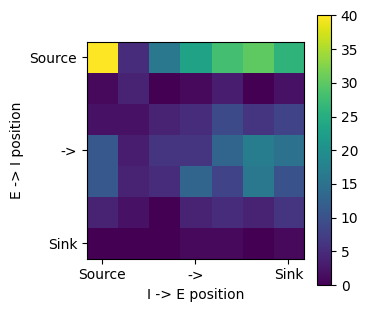

In [12]:
is_high_deg = numpy.all(nrn_degrees >= pandas.Series(cfg["analysis"]["min_degrees"]), axis=1)
rnd_smpl = numpy.random.choice(is_high_deg.index[is_high_deg])

I = analysis.get_disynaptic_path_sum(s_n_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     n_s_paths.reorder_levels([2, 1, 0])[rnd_smpl],
                                     tgt_dim, use_weight=bool(cfg["analysis"]["use_weight"]))
fig = plotting.plot_disynaptic_path_sum(I)

100%|████████████████████████████████████████████████████████████████████████████████| 648/648 [00:01<00:00, 484.81it/s]


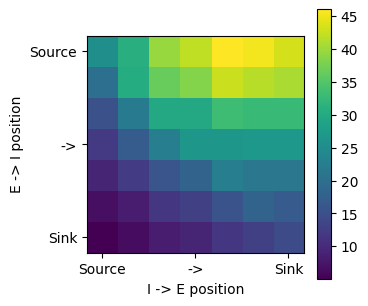

In [13]:
I = analysis.sum_disynaptic_path_sum(s_n_paths, n_s_paths, tgt_dim, name_nrn,
                                     min_degree=cfg["analysis"]["min_degrees"],
                                     use_weight=bool(cfg["analysis"]["use_weight"]))
fig = plotting.plot_disynaptic_path_sum(I)

In [14]:
tgt_shape = (len(df_gid), len(Mnrn))
disyn_nrn_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                use_weight=bool(cfg["analysis"]["use_weight"]),
                                                normalize=bool(cfg["analysis"].get("normalize_mat", 0)))
disyn_ctrl_mat = analysis.get_disynaptic_con_mat(s_n_paths, n_s_paths, name_nrn, tgt_shape,
                                                 use_weight=bool(cfg["analysis"]["use_weight"]),
                                                 normalize=bool(cfg["analysis"].get("normalize_mat", 0)),
                                                 shuffle_cols=[name_nrn])

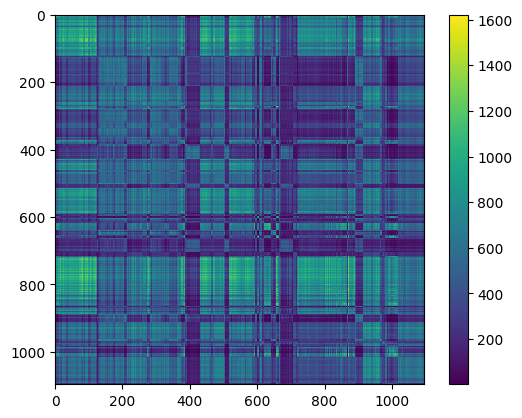

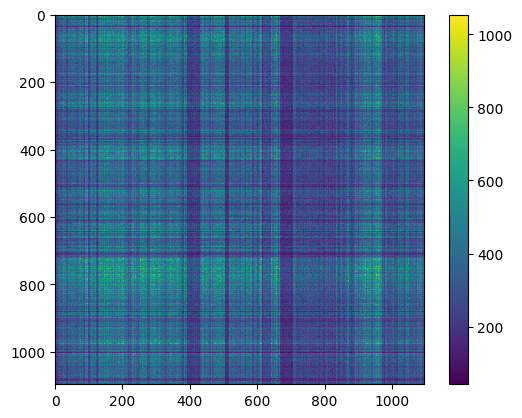

In [15]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow((disyn_nrn_mat), interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow((disyn_ctrl_mat), interpolation="nearest"))

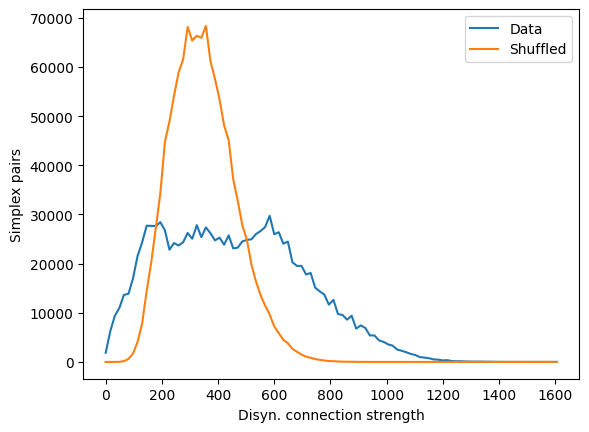

In [16]:
def compare_disyn_inhibition(m_data, m_ctrl):
    bins = numpy.linspace(0, m_data.max(), 101)
    H_data = numpy.histogram(m_data.flatten(), bins=bins)[0]
    H_ctrl = numpy.histogram(m_ctrl.flatten(), bins=bins)[0]

    plt.plot(bins[:-1], H_data, label="Data")
    plt.plot(bins[:-1], H_ctrl, label="Shuffled")

    plt.gca().set_xlabel("Disyn. connection strength")
    plt.gca().set_ylabel("Simplex pairs")
    plt.legend()

fig = plotting.compare_disyn_inhibition(disyn_nrn_mat, disyn_ctrl_mat)

In [17]:
print(numpy.var(disyn_ctrl_mat - disyn_ctrl_mat.transpose()) / numpy.var(disyn_ctrl_mat))
print(numpy.var(disyn_nrn_mat - disyn_nrn_mat.transpose()) / numpy.var(disyn_nrn_mat))

2.432941088470628
0.7564072320611418


In [37]:
def simplex_overlap_in_positions(data_df, pos_idx, ugid):
    from scipy import sparse
    use_idx = data_df[pos_idx]
    shape = (len(data_df), len(ugid))

    mbr_mat = sparse.csr_matrix((numpy.ones(numpy.prod(use_idx.shape), dtype=int),
                                use_idx.values.flatten(),
                                numpy.arange(len(use_idx) + 1, dtype=int) * use_idx.shape[1]),
                                shape=shape)
    assert numpy.all(numpy.array(mbr_mat.sum(axis=1)).flatten() == use_idx.shape[1])
    return numpy.array((mbr_mat * mbr_mat.transpose()).todense())

_sz = tgt_dim + 1
_idx_low = numpy.arange(int(numpy.floor(_sz / 2)))
_idx_high = numpy.arange(int(numpy.ceil(_sz / 2)), _sz)

ol_src = simplex_overlap_in_positions(df_idx, _idx_low, ugid)
ol_tgt = simplex_overlap_in_positions(df_idx, _idx_high, ugid)
ol_all = simplex_overlap_in_positions(df_idx, numpy.arange(tgt_dim + 1), ugid)

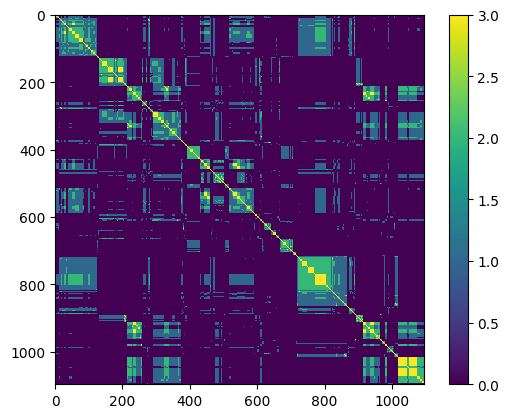

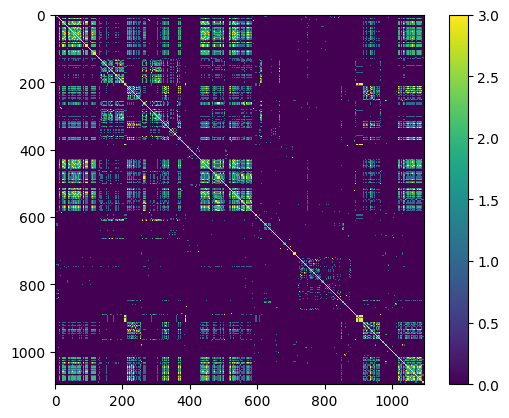

In [19]:
fig1 = plt.figure()
ax = fig1.gca()
plt.colorbar(ax.imshow(ol_src, interpolation="nearest"))

fig2 = plt.figure()
ax = fig2.gca()
plt.colorbar(ax.imshow(ol_tgt, interpolation="nearest"))

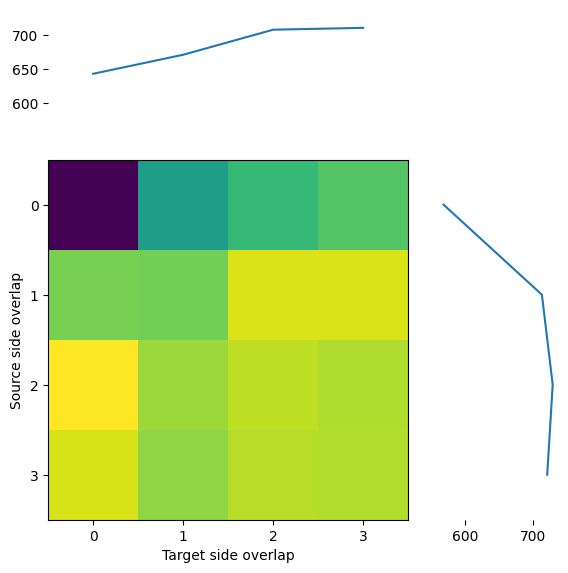

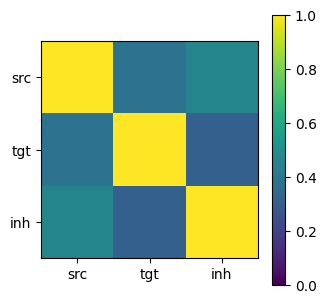

In [20]:
ol_disyn_mat, ol_disyn_cc, column_names = analysis.overlaps_vs_disyn(ol_src, ol_tgt, disyn_nrn_mat)
fig1 = plotting.plot_overlaps_vs_disyn(ol_disyn_mat)
fig2 = plotting.plot_overlap_vs_disyn_corr(ol_disyn_cc, column_names)

13
211


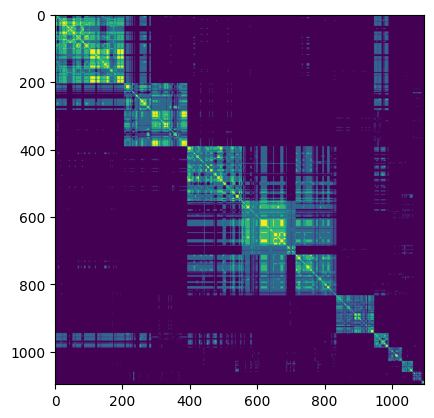

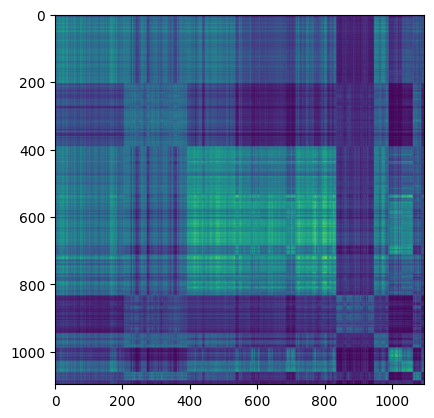

In [21]:
grp_df_full = analysis.simplex_clustering(ol_src, ol_tgt, cfg["analysis"]["clustering"]["cluster_param"])

if "merge_smaller_than" in cfg["analysis"]["clustering"]:
    grp_df = analysis.merge_small_clusters(grp_df_full, cfg["analysis"]["clustering"]["merge_smaller_than"])
else:
    grp_df = grp_df_full

lbls_src = grp_df["src_grp"]
lbls_tgt = grp_df["tgt_grp"]

idx = numpy.argsort(lbls_src)
plt.figure().gca().imshow(ol_src[numpy.ix_(idx, idx)])

plt.figure().gca().imshow(disyn_nrn_mat[numpy.ix_(idx, idx)])

In [71]:
cfg["analysis"]["clustering"]["normalize_cluster_paths"] = "pairs"
cfg["analysis"]["clustering"]["normalize_cluster_disyn"] = "pairs"

In [72]:
clst_mat_smplx = analysis.simplex_cluster_connectivity(df_idx, grp_df, ugid, cfg["analysis"]["clustering"]["normalize_cluster_paths"])

co = cfg["analysis"]["clustering"]["cutoff"]

if co["strategy"] == "percentile":
    cutoff = numpy.percentile(disyn_nrn_mat.flatten(), co["value"])
elif co["strategy"] == "percentile_control":
    cutoff = numpy.percentile(disyn_ctrl_mat.flatten(), co["value"])
elif co["strategy"] == "none":
    cutoff = None
elif co["strategy"] == "value":
    cutoff = co["value"]

clst_mat_disyn = analysis.simplex_cluster_disyn(disyn_nrn_mat, grp_df, cfg["analysis"]["clustering"]["normalize_cluster_disyn"], cutoff=cutoff)

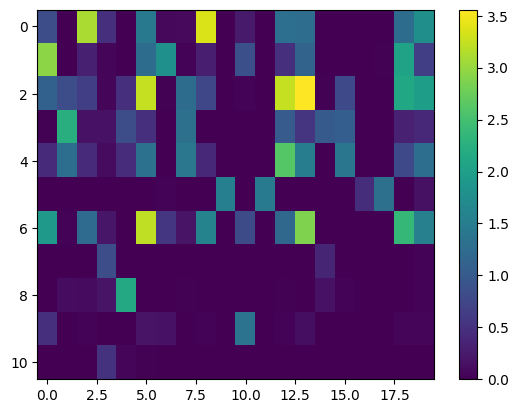

In [73]:
plt.colorbar(plt.imshow(clst_mat_smplx, aspect="auto", interpolation="nearest"))

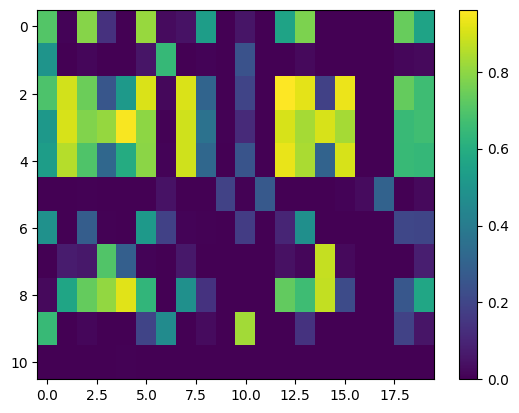

In [74]:
plt.colorbar(plt.imshow(clst_mat_disyn, aspect="auto", interpolation="nearest"))

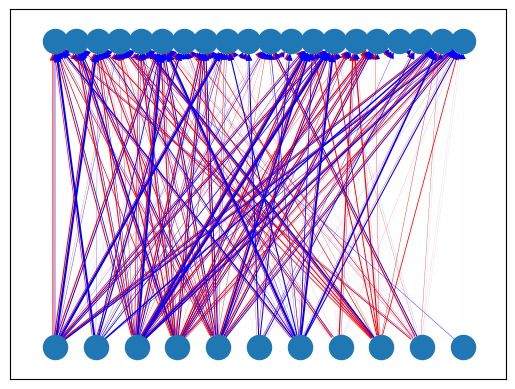

In [89]:
n, m = clst_mat_smplx.shape
Mm = numpy.vstack([
    numpy.hstack([numpy.zeros((n, n)), clst_mat_smplx]),
    numpy.zeros((m, n + m))])
Mn = numpy.vstack([
    numpy.hstack([numpy.zeros((n, n)), clst_mat_disyn]),
    numpy.zeros((m, n + m))])
import networkx

x = numpy.hstack([numpy.linspace(0, 1, n), numpy.linspace(0, 1, m)])
y = numpy.hstack([numpy.zeros(n), numpy.ones(m)])


grph = networkx.DiGraph(Mn)
weights = []
for e in grph.edges:
    weights.append(Mn[e[0], e[1]])

weights = numpy.array(weights) / 1
networkx.draw_networkx(grph, numpy.vstack([x, y]).transpose(),
                      width=weights, with_labels=False, nodelist=[], edge_color="red")

grph = networkx.DiGraph(Mm)
weights = []
for e in grph.edges:
    weights.append(Mm[e[0], e[1]])

weights = numpy.array(weights) / 2
networkx.draw_networkx(grph, numpy.vstack([x + 0.005, y]).transpose(),
                      width=weights, with_labels=False, edge_color="blue")


Text(0, 0.5, 'Inhibition')

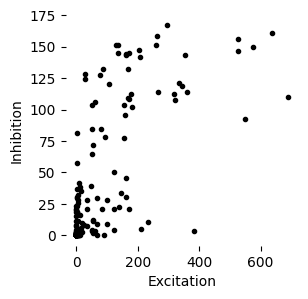

In [25]:
fig = plt.figure(figsize=(3, 3))
ax = fig.gca()
ax.plot(clst_mat_smplx.flatten(), clst_mat_disyn.flatten(), 'k.')
ax.set_frame_on(False)
ax.set_xlabel("Excitation")
ax.set_ylabel("Inhibition")

Finding the I neurons most participating in these motifs

In [26]:
N_S = n_s_paths.reset_index().groupby(["Inhibitory", "Position"])[0].count().unstack("Position", fill_value=0)
S_N = s_n_paths.reset_index().groupby(["Inhibitory", "Position"])[0].count().unstack("Position", fill_value=0)

In [27]:
N_Ssum = N_S.sum(axis=1)
S_Nsum = S_N.sum(axis=1)

N_Sdiff = N_S[6] - N_S[0]
S_Ndiff = S_N[0] - S_N[6]

In [28]:
cand = (N_Ssum > 400) & (S_Nsum > 400) & (N_Sdiff > 200) & (S_Ndiff > 200)
cand.index[cand].values

array([ 336,  371,  453,  630, 1092, 1185, 1370, 1546, 1686, 1692, 2300,
       2403, 2501, 3133, 3445, 3693, 4254, 4384, 4431, 4513, 4713, 4778,
       5340, 5569], dtype=int32)

In [29]:
Mnrn.vertices["cell_type"].value_counts()

cell_type
BC     2732
MC     2375
NGC     688
Name: count, dtype: int64

In [30]:
Mnrn.vertices.iloc[cand.index[cand].values]["cell_type"].value_counts()

cell_type
BC    19
MC     5
Name: count, dtype: int64

In [31]:
Mnrn.vertices.iloc[cand.index[cand].values]

,index,pt_root_id,id,valid,cell_type,pt_supervoxel_id,status_dendrite,status_axon,x_nm,y_nm,z_nm,indegree,outdegree,tentative_region
336,4523,864691135207719033,335669,t,BC,91989267089479318,empty,empty,791552,759808,949960,1264.0,3766.0,visp
371,4886,864691135210129088,426571,t,BC,99654375030638109,empty,empty,1014208,608960,969680,1267.0,6033.0,visp
453,6119,864691135272287761,363890,t,BC,94235363320605556,empty,empty,856448,589184,985160,981.0,3968.0,visp
630,7979,864691135341158321,368398,t,BC,96139786179544934,empty,empty,913536,722368,989640,861.0,4901.0,visp
1092,12912,864691135440462664,399422,t,BC,96352060442280429,empty,empty,918272,757824,942000,975.0,3338.0,visp
1185,13694,864691135462233757,370589,t,BC,94664585306940575,empty,empty,868608,798720,1040200,788.0,1683.0,visp
1370,15798,864691135487796210,399475,t,BC,97407179287886792,empty,empty,949696,745792,935240,403.0,1441.0,visp
1546,17572,864691135502196917,335772,t,BC,92340423682719058,empty,empty,802944,738432,970960,642.0,3988.0,visp
1686,18762,864691135536812484,397156,t,MC,97475761392938807,empty,empty,950912,691584,962400,812.0,4453.0,visp
1692,18803,864691135538058610,365842,t,BC,94871567967762097,empty,empty,875200,676224,902360,1243.0,3997.0,visp


PLOTTING THESE MOTIFS!

 2023-11-10 18:18:34,576: COMPUTE list of simplices by dimension


[<Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>,
 <Figure size 700x700 with 1 Axes>]

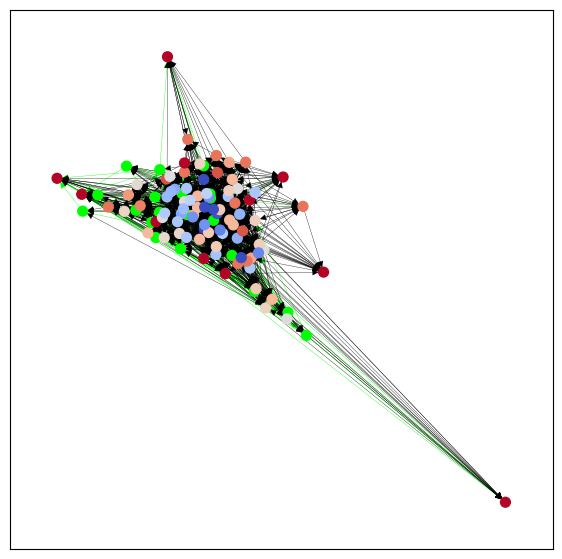

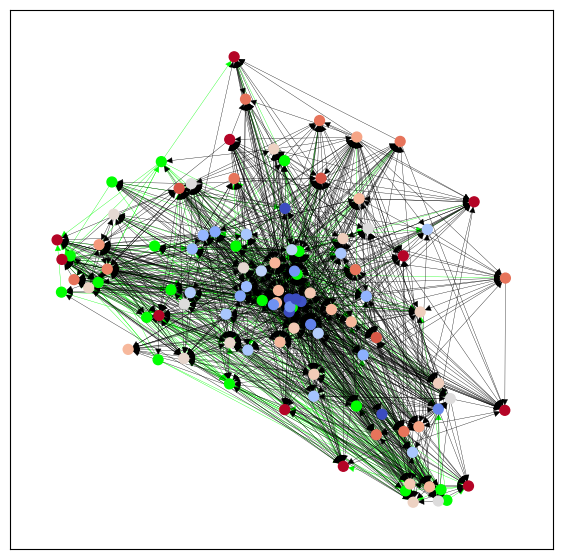

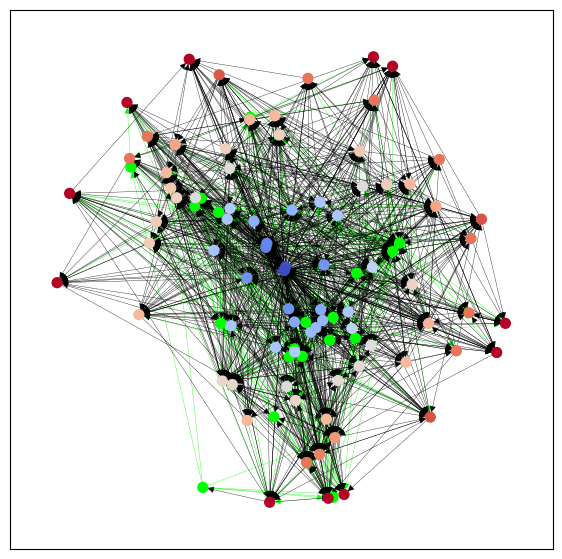

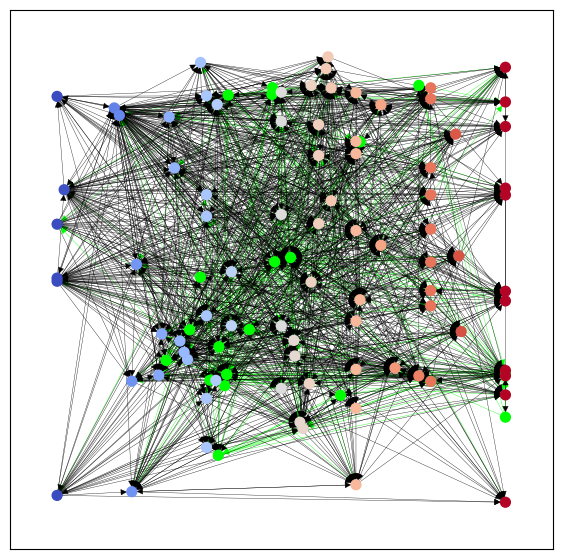

In [91]:
smplx_tgt_ids = grp_df.reset_index().set_index("src_grp")["index"][2]

plot_simplex_group_as_network(smplx_tgt_ids, M, Msmpl, Mnrn, simplices[tgt_dim],
                                       s_n_paths, n_s_paths, name_nrn, tgt_dim,
                                       cfg["plotting"]["networks"])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 121.46it/s]


ValueError: x and y must have same first dimension, but have shapes (44,) and (64,)

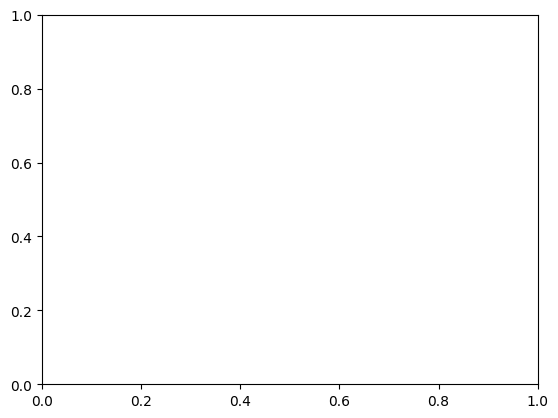

In [35]:
import tqdm

all_nrm = []
for _ in tqdm.tqdm(range(100)):
    pos = pandas.DataFrame(networkx.spring_layout(grph, iterations=50), index=["x", "y"]).transpose()
    pos = pos - pos.mean(axis=0)

    nrm = numpy.linalg.norm(pos, axis=1)
    all_nrm.append(nrm)

plt.plot(mean_loc.values, numpy.vstack(all_nrm).mean(axis=0), 'ok')
plt.errorbar(mean_loc.values, numpy.vstack(all_nrm).mean(axis=0),
             yerr=numpy.vstack(all_nrm).std(axis=0), ls="None",
            color="black")